# Measuring Supermassive Black Hole Mass with JAM and CapFit

<table>
  <tr>
    <td style="border: none"><a href="https://users.physics.ox.ac.uk/~cappellari/software/#sec:jam"><img src="https://users.physics.ox.ac.uk/~cappellari/images/jam-logo.svg" width="100"></a></td>
    <td style="border: none"><a href="https://users.physics.ox.ac.uk/~cappellari/software/#sec:capfit"><img src="https://users.physics.ox.ac.uk/~cappellari/images/capfit-logo.svg" width="100"></a></td>
  </tr>
</table>


This notebook demonstrates how to measure a supermassive black hole's mass using stellar dynamics. It applies the Jeans Anisotropic Modelling (JAM) method ([Cappellari 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.390...71C/abstract), [2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4819C/abstract)), implemented in the [`jampy`](https://pypi.org/project/jampy/) package, to fit a dynamical model to mock kinematic data. The optimization is performed with the robust CapFit least-squares algorithm ([Cappellari 2023, Sec.3.2](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C/abstract)) implemented in the [`capfit`](https://pypi.org/project/capfit/) package.

- **V1.0.0**: Written. Michele Cappellari, Oxford, 28 July 2025

## 1. Imports

We import the necessary packages for this analysis:
- Standard scientific Python libraries (`numpy`, `matplotlib`)
- `jampy`: Core package for Jeans Anisotropic Modelling
- `capfit`: Robust least-squares optimizer with constraints

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# All packages below are available at https://pypi.org/user/micappe/

import jampy as jam
import capfit

## 2. Galaxy Model and Observational Data

### Multi-Gaussian Expansion (MGE) Model

We use the MGE model for the galaxy M32 from [Cappellari et al. (2006)](http://adsabs.harvard.edu/abs/2006MNRAS.366.1126C). M32 is an ideal target for black hole studies because:
- It is a compact elliptical galaxy with a known central black hole
- It has been extensively studied with high-resolution spectroscopy

The MGE parameterization allows for analytic solutions of the gravitational potential and Jeans equations, making it computationally efficient for parameter fitting.

In [2]:
# MGE model of M32 from Table B1 of Cappellari et al. (2006) http://adsabs.harvard.edu/abs/2006MNRAS.366.1126C
surf = 10**np.array([6.187, 5.774, 5.766, 5.613, 5.311, 4.774, 4.359, 4.087, 3.682, 3.316, 2.744, 1.618])
sigma = 10**np.array([-1.762, -1.143, -0.839, -0.438, -0.104, 0.232, 0.560, 0.835, 1.160, 1.414, 1.703, 2.249])
qObs = np.array([0.790, 0.741, 0.786, 0.757, 0.720, 0.724, 0.725, 0.743, 0.751, 0.838, 0.835, 0.720])

### Mock Kinematic Data

We load mock kinematic data that simulates realistic observations with appropriate noise levels. Using mock data is crucial for validating our analysis pipeline—we can test whether we can accurately recover known input parameters before applying the method to real data where the ground truth is unknown.

The mock data includes realistic observational effects such as:
- Finite spatial resolution (PSF convolution)
- Photon noise in velocity measurements

In [3]:
# Read mock kinematics with realistic parameters and noise
jam_dir = Path(jam.__file__).parent
filename = jam_dir / 'examples/jam_mock_kinematics_black_hole.txt'
xbin, ybin, rms, erms, flux = np.loadtxt(filename).T
distance = 0.7   # M32 Distance in Mpc

## 3. Model Setup and Assumptions

### Mass Model Assumptions

For this black hole mass measurement, we make the following simplifying assumptions:
1. **Mass follows light**: The stellar mass distribution is proportional to
   the observed light distribution, scaled by a constant mass-to-light ratio $(M/L)$
2. **No dark matter**: We neglect dark matter, which is reasonable for the central regions of early-type galaxies where stellar mass dominates and the total density slope is close to the stellar density slope
3. **Constant anisotropy**: We assume the anisotropy parameter is constant throughout the galaxy: $\beta_z = 1 - \sigma_z^2/\sigma_R^2$ for cylindrical alignment, or $\beta_r = 1 - \sigma_\theta^2/\sigma_r^2$ for spherical alignment. This is a reasonable first approximation for the central regions, though modelling spatial variations is possible.

These assumptions are commonly used in black hole studies and are generally valid for the central regions where the black hole's influence is strongest.

In [4]:
# Here assume mass follows light (no dark matter in central regions)
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs

### Observational Setup

We define the observational parameters that characterize our kinematic data:
- **PSF modeling**: Critical for high-resolution observations. We use a double-Gaussian PSF typical of adaptive optics systems. This has to be determined from the data.
- **Pixel scale**: The spatial sampling of our kinematic measurements
- **Alignment of the velocity ellipsoid**: We can choose between two limiting cases for the alignment of the velocity ellipsoid: cylindrical (`cyl`) or spherical (`sph`).

In [5]:
# Initial parameter guesses (e.g., from previous analysis or literature)
q0 = 0.5                # Intrinsic axial ratio
bh0 = 2e6               # Black hole mass in solar masses
lg_ml0 = 0              # Log10 of mass-to-light ratio
ratio0 = 1              # Anisotropy ratio sigma_z/sigma_R
align = 'cyl'           # Cylindrical alignment for axisymmetric systems

# Typical Adaptive-Optics PSF: narrow core + broad wings
sigmapsf = [0.04, 0.4]  # sigma PSF in arcsec for double-Gaussian PSF
normpsf = [0.7, 0.3]    # Relative normalizations
pixsize = 0.05          # Pixel size in arcsec

### Parameter Bounds and Priors

We establish physically motivated bounds for our fitting parameters to ensure the optimizer converges to meaningful solutions. The bounds are based on:
- **Geometric constraints**: The intrinsic axial ratio cannot be larger than the observed flattening
- **Physical priors**: Anisotropy parameters are constrained to physically reasonable ranges
    * For cylindrically aligned velocity ellipsoids, we allow isotropic or flattened velocity ellipsoids [(Cappellari 2025, fig.8 left)](https://ui.adsabs.harvard.edu/abs/2025arXiv250302746C) 
    * For spherical alignment, we allow isotropic to tangentially anisotropic orbits given that we are close to the black hole [(Cappellari 2025, fig.10)](https://ui.adsabs.harvard.edu/abs/2025arXiv250302746C). An even better choice would be to use the `logistic` anisotropy keyword in `jampy`, which allows for a more flexible anisotropy profile. But this is beyond the scope of this simple example.

In [6]:
# Priors are generally recommended to avoid unphysical fits
if align == 'cyl':
    ratio_min, ratio_max = 0.5, 1      # Cylindrical: isotropic or flattened velocity ellipsoid
elif align == 'sph':
    ratio_min, ratio_max = 1, 1.5      # Spherical: isotropic to tangentially anisotropic

# Starting parameters and bounds for the fit
qmin = np.min(qObs)  # Minimum allowed axial ratio from MGE
p0 =      [q0,    ratio0,    bh0,    lg_ml0]
bounds = [[0.051, ratio_min, bh0/10, lg_ml0-2], 
          [qmin,  ratio_max, bh0*10, lg_ml0+2]]

### Data Selection for Analysis

We define which spatial bins to include in our fit. As an illustration I show
below the option of 
1. **Full 2D fit**: fitting all integral-field bins
2. **Major/minor axis fit**: selecting bins along the major and minor axes to mimic long-slit kinematics

In [7]:
# Select bins close to the major and minor axes for plotting
dang = 15  # Angle tolerance in degrees
major = (np.abs(ybin) < pixsize/2) | (np.arctan2(np.abs(ybin), np.abs(xbin)) < np.radians(dang))
minor = (np.abs(xbin) < pixsize/2) | (np.arctan2(np.abs(xbin), np.abs(ybin)) < np.radians(dang))

fit_all_bins = True  # Set to False to fit only major/minor axes
goodbins = np.isfinite(xbin) if fit_all_bins else (major | minor)

## 4. Model Implementation

### Residual Function

The core of our fitting procedure is the `jam_residuals` function, which:
1. Takes a set of model parameters as input
2. Constructs the 3D mass model (stars + black hole)
3. Solves the Jeans equations to predict stellar kinematics
4. Compares predictions with observations and returns normalized residuals

The normalized residuals $(\mathrm{data} - \mathrm{model})/\mathrm{error}$ are used by the optimizer to find the best-fit parameters through $\chi^2$ minimization.

In [8]:
def jam_residuals(pars):
    """Return the residuals of the model, given the data and parameters."""

    q, ratio, mbh, lg_ml = pars
    
    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    # This accounts for the projection of the intrinsic 3D shape onto the sky
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta = np.full_like(qobs_lum, 1 - ratio**2)   # Convert anisotropy ratio to β parameter

    # Call JAM to compute predicted kinematics
    # Note: surf_pot is multiplied by 10**lg_ml to scale stellar mass, while ml=1
    out = jam.axi.proj(surf_lum, sigma_lum, qobs_lum, surf_pot*10**lg_ml, sigma_pot, qobs_pot,
                    inc, mbh, distance, xbin, ybin, plot=False, pixsize=pixsize, quiet=1,
                    sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                    beta=beta, data=rms, errors=erms, ml=1)

    jam_residuals.out = out  # Store output for plotting

    # Return normalized residuals for chi-squared minimization
    resid = (rms[goodbins] - out.model[goodbins])/erms[goodbins]

    return resid

### Real-time Monitoring

We implement a monitoring function that provides real-time visualization of the fit progress. This is invaluable for:
- Assessing convergence behavior
- Identifying potential fitting problems early
- Understanding how parameter changes affect the model

The monitor function is called at each iteration and displays the current best-fit model compared to the data.

In [13]:
def monitor_plot(pars, niter, chi2):
    """
    This function is called by capfit at each iteration
    to display the progress of the fit.
    """
    plt.figure(figsize=(4, 4/1.3))  # Create a new figure for the final plot
    jam_residuals.out.plot()
    plt.pause(0.01)

plot = True  # Set to False to disable plotting
monitor = {"fun": monitor_plot, "num": 1} if plot else None

## 5. CapFit Parameter Optimization

We use the CapFit optimizer, which is a robust least-squares optimizer that supports a wide range of constraints:
- **Bound constraints**: Simple upper and lower limits on parameters
- **Linear equality/inequality constraints**: For example, $A x = b$ or $A x \leq b$
- **Tied parameters**: Enforce non-linear relationships between parameters
- **Fixed parameters**: Any parameter can be held fixed without changing the fitting function

CapFit implements Algorithm 2 from [Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.5289C/abstract), combining two powerful optimization strategies:
- **Sequential Quadratic Programming (SQP)** for handling constraints
- **Levenberg-Marquardt (LM)** for efficient and robust least-squares minimization

In practice, CapFit acts as a Levenberg-Marquardt algorithm, but, unlike the original method, it has full support for constraints. CapFit typically requires fewer function evaluations and is more robust than standard unconstrained or bound-constrained least-squares algorithms, while also allowing for more general constraints.


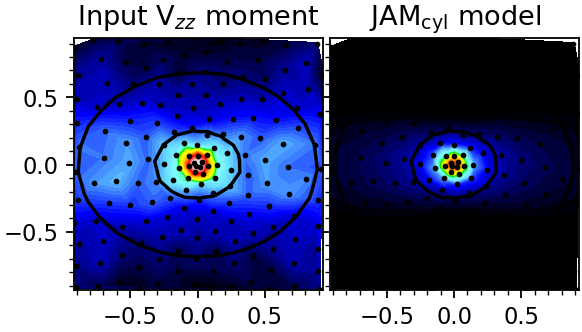


Start lambda: 385.4  chi2: 1481.
Start p[free]: 0.5000 1.000 2.000e+06 0.000

iter: 1  lambda: 385.4  chi2: 175.5  ratio: 0.9982
p[free]: 0.3404 0.9520 2.432e+06 0.1494
dp: -0.1596 -0.04798 4.325e+05 0.1494


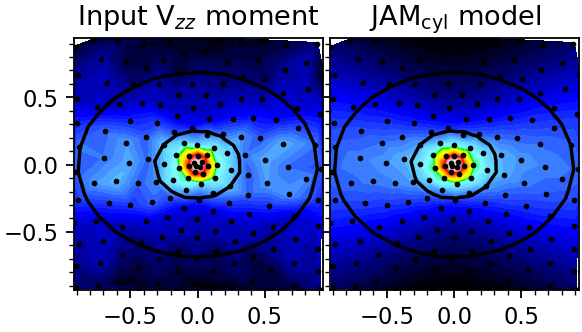


iter: 2  lambda: 192.7  chi2: 172.8  ratio: 0.9996
p[free]: 0.3636 0.9409 2.425e+06 0.1433
dp: 0.02319 -0.01110 -7936. -0.006102


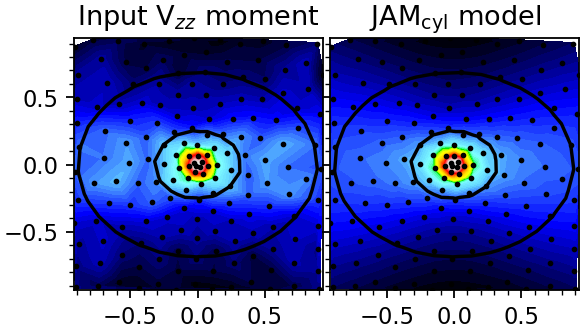


iter: 3  lambda: 96.35  chi2: 172.8  ratio: 1.006
p[free]: 0.3665 0.9435 2.429e+06 0.1431
dp: 0.002923 0.002619 4262. -0.0001548


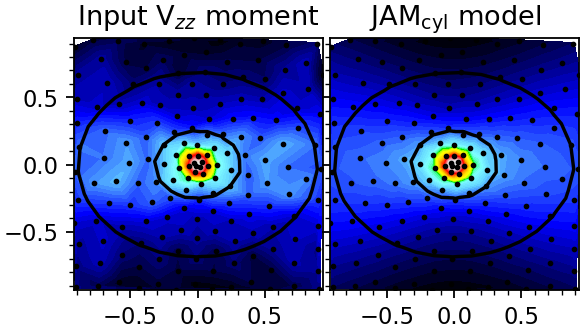


Terminating on small function variation (ftol)
Final iter: 3  Func calls: 16  chi2: 172.8  Status: 2
Final p[free]: 0.3665 0.9435 2.429e+06 0.1431



In [ ]:
# Perform the optimization
# Optionally fix some parameters with fixed=[1,0,0,0] to fix the first parameter
res = capfit.capfit(jam_residuals, p0, bounds=bounds, verbose=2, 
                    monitor=monitor, abs_step=0.01, fixed=[0, 0, 0, 0])

## 6. Results Analysis and Visualization

### Final Model Comparison

We create a comprehensive visualization showing:
1. **Data vs. Model**: Direct comparison along major and minor axes
2. **Parameter values**: Best-fit parameters with properly scaled uncertainties

### Parameter Uncertainties and Statistical Analysis

We compute properly scaled parameter uncertainties by accounting for potential underestimation of observational errors. The scaling factor $\sqrt{\chi^2/\mathrm{DOF}}$ inflates the formal uncertainties when the reduced chi-squared exceeds unity, which often occurs in real astronomical data due to systematic effects not captured in the formal error budget.

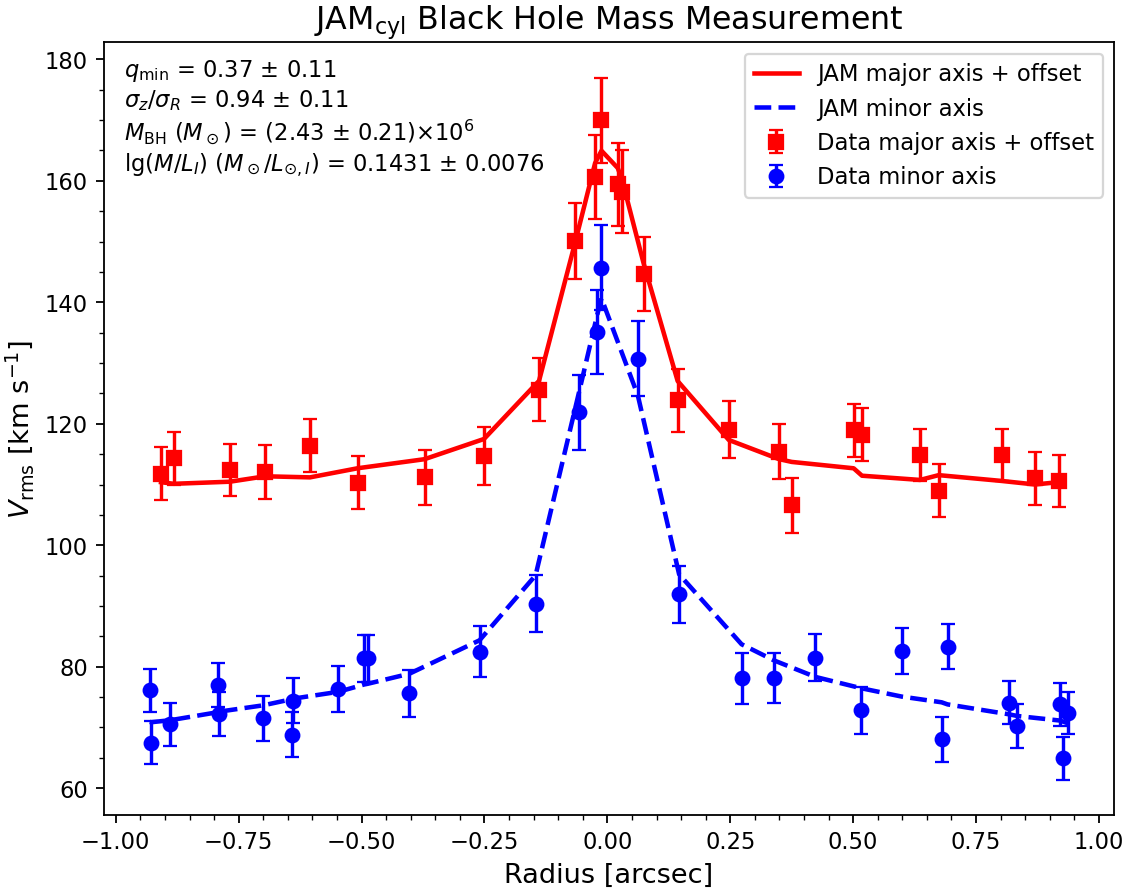

In [11]:
plt.figure(figsize=(8, 8/1.3))  # Create a new figure for the final plot
rmsModel = jam_residuals.out.model
offs = np.median(rms)*0.3  # Offset for visual separation

# Plot major axis data and model
w = np.argsort(xbin[major])
plt.plot(xbin[major][w], rmsModel[major][w] + offs, 'r-', linewidth=2, label='JAM major axis + offset')
plt.errorbar(xbin[major], rms[major] + offs, yerr=erms[major],
                fmt='s', color='red', markersize=6, capsize=3, label='Data major axis + offset')

# Plot minor axis data and model
w = np.argsort(ybin[minor])
plt.plot(ybin[minor][w], rmsModel[minor][w], '--b', linewidth=2, label='JAM minor axis')
plt.errorbar(ybin[minor], rms[minor], yerr=erms[minor],
                fmt='o', color='blue', markersize=6, capsize=3, label='Data minor axis')

plt.xlabel("Radius [arcsec]", fontsize=12)
plt.ylabel(r"$V_{\rm rms}$ [km s$^{-1}$]", fontsize=12)
plt.title(rf"JAM$_\mathrm{{{align}}}$ Black Hole Mass Measurement", fontsize=14)

ax = plt.gca()

# Calculate scaled errors for chi2/DOF = 1 (accounts for potential error underestimation)
dof = rms.size - (res.x_err > 0).sum()  # Degrees of freedom
scaled_errors = res.x_err * np.sqrt(res.chi2 / dof)

# Format all parameters with their errors
labels = [
    r"$q_{\rm min}$",
    r"$\sigma_z/\sigma_R$" if align == 'cyl' else r"$\sigma_\theta/\sigma_r$",
    r"$M_{\rm BH}$ ($M_\odot$)",
    r"$\lg(M/L_I)$ $(M_\odot/L_{\odot,I})$"
]

# Add results text to the plot
txt = capfit.format_values_with_errors(res.x, scaled_errors, labels)
plt.text(0.02, 0.98, txt.latex, transform=ax.transAxes, va='top', ha='left')
plt.legend()
plt.show()